In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sodapy import Socrata
import datetime as dt
import os
pd.set_option('display.max_columns', None)

In [2]:
client = Socrata("data.austintexas.gov", None)

In [4]:
#AAC INTAKES DATA
in_result = client.get("wter-evkm", limit=150000)
intakes = pd.DataFrame(in_result)

In [3]:
#AAC OUTCOMES DATA 
out_result = client.get("9t4d-g238", limit=150000)
outcomes = pd.DataFrame(out_result)

In [6]:
#SHOW WHERE THE TWO DFS HAVE COMMON COLUMNS
col_intersect = sorted(list(set(intakes.columns).intersection(set(outcomes.columns))))
col_intersect.remove("datetime")

In [8]:
#MERGE INTAKES AND OUTCOMES TOGETHER ON ANIMAL IDS EXISTING IN BOTH DFS 
ddf = pd.merge(intakes, outcomes, on=col_intersect,suffixes=('_in', '_out') )
ddf = ddf[sorted(df.columns)]

In [64]:
df = ddf.copy()

In [5]:
intakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125929 entries, 0 to 125928
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal_ID         125929 non-null  object        
 1   Name              86252 non-null   object        
 2   DateTime          125929 non-null  datetime64[ns]
 3   MonthYear         125929 non-null  datetime64[ns]
 4   Found_Location    125929 non-null  object        
 5   Intake_Type       125929 non-null  object        
 6   Intake_Condition  125929 non-null  object        
 7   Animal_Type       125929 non-null  object        
 8   Sex_upon_Intake   125928 non-null  object        
 9   Age_upon_Intake   125929 non-null  object        
 10  Breed             125929 non-null  object        
 11  Color             125929 non-null  object        
dtypes: datetime64[ns](2), object(10)
memory usage: 11.5+ MB


In [6]:
col_intersect = sorted(list(set(intakes.columns).intersection(set(outcomes.columns))))
col_intersect.remove("DateTime")
col_intersect.remove("MonthYear")

In [7]:
print("intakes:    ",len(intakes))
print("outcomes:   ",len(outcomes))
print("total rows: ", len(intakes)+len(outcomes))
print("unique #:   ", len(pd.merge(intakes, outcomes, how='inner', on=col_intersect)))

intakes:     125929
outcomes:    126165
total rows:  252094
unique #:    162656


In [8]:
df = pd.merge(intakes, outcomes, on=col_intersect,suffixes=('_in', '_out') )
df.sort_index(axis=1,inplace=True)

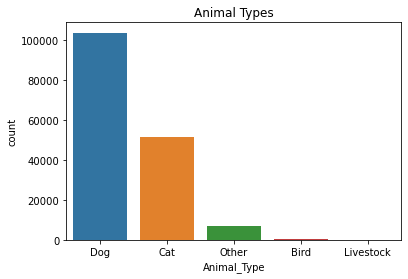

In [9]:
sns.countplot(x='Animal_Type', data=df)
plt.title('Animal Types')
plt.show()

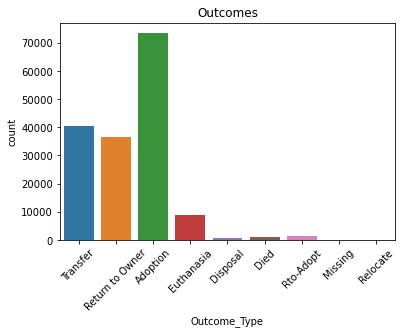

In [10]:
ax = sns.countplot(x='Outcome_Type', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.title('Outcomes')
plt.show()

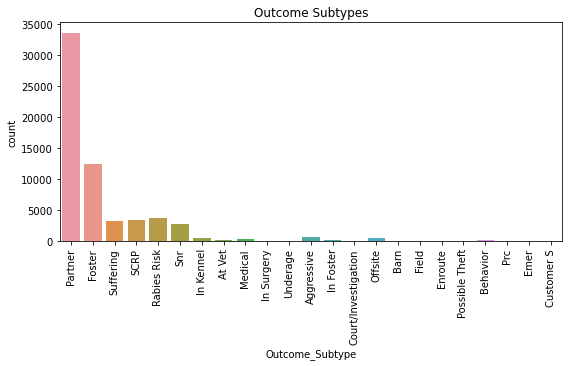

In [81]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='Outcome_Subtype', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.title('Outcome Subtypes')
plt.show()

In [82]:
df.drop(index=df[df.Age_upon_Outcome.isna()==True].index, inplace=True)
#MONTHYEAR IS SAME AS DATETIME
df.drop(columns=['MonthYear_in', 'MonthYear_out'],inplace=True)

In [83]:
# LOOK FOR WHEN DATETIME_IN IS EARLIER THAN DATE_OF_BIRTH
wrong_dob = (df.Date_of_Birth > df.DateTime_in)
#likely reasoning is DateTime_in is when the mother was brought into the center and the DOB is when the babies were born
#given this assumption, change all DateTime_in to DOB 
df.loc[wrong_dob, ['DateTime_in']] = df.loc[wrong_dob, ['Date_of_Birth']].values

In [84]:
# LOOK FOR AND SWITCH WHEN DATETIME_IN IS LATER THAN DATETIME_OUT
idx = (df.DateTime_out<df.DateTime_in)
#IF IN IS LATER THAN OUT, SWTICH
df.loc[idx,['DateTime_out','DateTime_in']] = df.loc[idx,['DateTime_in','DateTime_out']].values
#AGES APPEAR TO BE SWITCHED FOR ALL OF THESE OBSERVATIONS AS WELL. SWITCH THESE TWO COLUMNS
df.loc[idx,['Age_upon_Outcome', 'Age_upon_Intake']] = df.loc[idx,['Age_upon_Intake', 'Age_upon_Outcome']].values

In [85]:
# CREATE A TRUE DURATION IN DAYS FOR IN/OUT 
df['Duration_Days']= (df.DateTime_out - df.DateTime_in).dt.days 

#GIVEN AGES AREN'T RELIABLE. 
#CALCULATE AGE UPON INTAKE USING DATE OF BIRTH AND DATETIMEIN
#CALCULATE AGE UPON OUTCOME USING DATE OF BIRTH AND DATETIMEOUT
df['Calc_Age_In'] = round((df['DateTime_in'] - df['Date_of_Birth'])/ np.timedelta64(1, 'Y'),1)
df['Calc_Age_Out'] = round((df['DateTime_out'] - df['Date_of_Birth'])/ np.timedelta64(1, 'Y'),1)

In [86]:
#Create Alternative to Altered Status + Sex in each intake and outcome 
df['Altered'] = df['Sex_upon_Intake']!=df['Sex_upon_Outcome']
df['Sex'] = df.Sex_upon_Intake.str.split(" ").str[-1]
#Can drop sex_upon_ columns 

In [87]:
df.sort_index(axis=1,inplace=True)

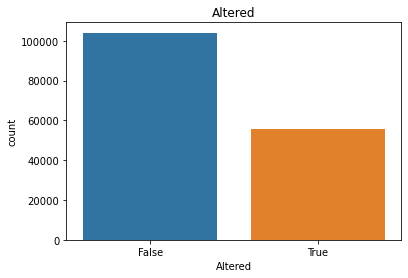

In [88]:
sns.countplot(x='Altered', data=df)
plt.title('Altered')
plt.show()

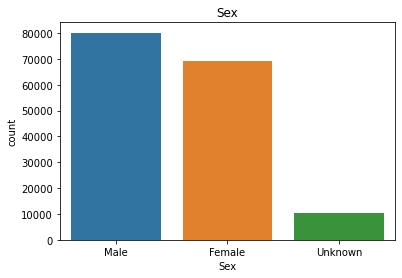

In [89]:
sns.countplot(x='Sex', data=df)
plt.title('Sex')
plt.show()

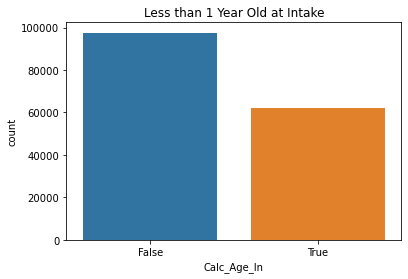

In [92]:
sns.countplot(df['Calc_Age_In'] <1)
plt.title('Less than 1 Year Old at Intake')
plt.show()

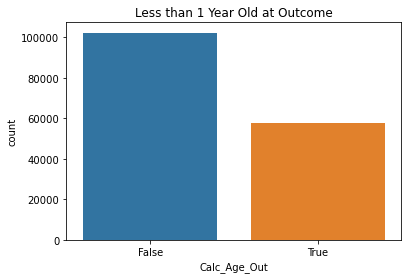

In [93]:
sns.countplot(df['Calc_Age_Out'] <1)
plt.title('Less than 1 Year Old at Outcome')
plt.show()

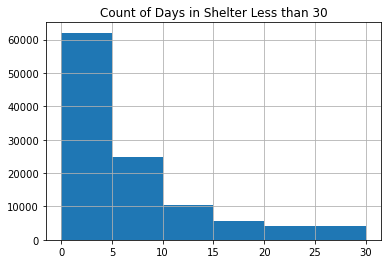

In [102]:
df['Duration_Days'].hist(bins=6,range=(0,30))
plt.title('Count of Days in Shelter Less than 30')
plt.show()

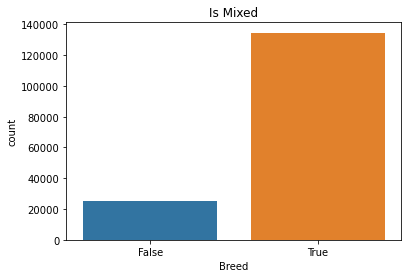

In [118]:
sns.countplot(df.Breed.str.contains("Mix|/"))
plt.title("Is Mixed")
plt.show()

In [121]:
df[df['Breed'].str.contains("-")].Animal_Type.value_counts()
#"-" in Breed doesn't mean mixed 
# "-" is only in "other" animal types

Other    71
Name: Animal_Type, dtype: int64

In [187]:
dog = df[df.Animal_Type=="Dog"]